# Dilepton analysis  (Python) 


This is an example of a simple dilepton analysis, quite similar to the notebook called "Dilepton_analysis_noData.ipynb", but with some differences. The most obvious difference is that we here also include real data. This example also has a slightly more advanced event selection.  

**Notice:** This is *only an example* on how to do this. Feel free to be creative, and to find better and/or more elegant ways of doing the various steps! 

In [1]:
import ROOT as R

Welcome to JupyROOT 6.12/06


## 1. Reading the dataset

In [2]:
background = R.TChain("mini")
data = R.TChain("mini")

A list of all the background samples and their IDs can be found in **Background_samples.txt**. We read that list, and add all the samples to the TChain. We also (for later convenience) make a vector containing the dataset IDs. 

In [3]:
infile = open("Background_samples.txt", "r")

In [4]:
dataset_IDs = []
background.Reset()
infile = open("Background_samples.txt", "r")
for line in infile: 
    words = line.split()
    sample = words[0]
    DSID = int(words[1])
    dataset_IDs.append(DSID)
    background.Add("DataSamples/MC/"+sample)
infile.close() 

In [5]:
data.Reset(); 
data.Add("DataSamples/Data/DataEgamma.root"); 
data.Add("DataSamples/Data/DataMuons.root"); 

## 2. Making (a lot of) histograms

Now that we have read our dataset we want to start analyzing the data. To do so we need to put the data into histograms. For reasons that will become clear later in the analysis we must (for each variable) make one histogram per dataset ID. (We have 31 background samples, so if we want to study 10 variables we have to make 310 histograms!) For best dealing with all these histograms we can use dictionaries (Python) or maps (C++). 

In [6]:
hist_mll = {}; hist_lep_pt = {}; hist_met = {}; 

In [7]:
for i in dataset_IDs: 
    hist_mll[i] = R.TH1F() 
    hist_lep_pt[i] = R.TH1F()
    hist_met[i] = R.TH1F()

In [8]:
for i in dataset_IDs: 
    hist_mll[i].SetNameTitle("hist_mll", "Invariant mass"); 
    hist_lep_pt[i].SetNameTitle("hist_lep_pt", "Lepton pT"); 
    hist_met[i].SetNameTitle("hist_met", "Missing ET");
    hist_mll[i].SetBins(20,0,500); 
    hist_lep_pt[i].SetBins(20,0,1000);
    hist_met[i].SetBins(20,0,500); 

For data it is only necessary with one histogram for each variable: 

In [9]:
hist_mll_d = R.TH1F(); 
hist_lep_pt_d = R.TH1F(); 
hist_met_d = R.TH1F(); 

In [10]:
hist_mll_d.SetNameTitle("hist_mll", "Invariant mass"); 
hist_lep_pt_d.SetNameTitle("hist_lep_pt", "Lepton pT"); 
hist_met_d.SetNameTitle("hist_met", "Missing ET");
hist_mll_d.SetBins(20,0,500); 
hist_lep_pt_d.SetBins(20,0,1000);
hist_met_d.SetBins(20,0,500); 

### 2.1 Fill the histograms 
We can now loop over all events in our dataset, implement desired cuts, and fill the histograms we created above. In this example we choose only events containing exactly to same flavour leptons with opposite charge (i.e. $e^+e^-$ or $\mu^+\mu^-$). 
Before starting the loop we extract the total number of entries (events) in the TChain. We also make [TLorentzVector](https://root.cern.ch/doc/master/classTLorentzVector.html)s, which are very practical for handling the kinematics of the leptons, e.g. calculating the invariant mass of the two leptons. 

In [11]:
for i in dataset_IDs: 
    hist_mll[i].Reset(); 
    hist_lep_pt[i].Reset(); 
    hist_met[i].Reset();

In [12]:
hist_mll_d.Reset(); 
hist_lep_pt_d.Reset(); 
hist_met_d.Reset(); 

In [14]:
l1 = R.TLorentzVector() 
l2 = R.TLorentzVector() 
dileptons = R.TLorentzVector() 

In [ ]:
isData = 0; 

if isData == 1: ds = data 
else: ds = background     

i = 0     
for event in ds: 
    
    if i%1000000 == 0 and i>0: 
        print i
    i += 1 
    ## Data quality cuts: 
    
    if ds.passGRL == 0: continue
    if ds.hasGoodVertex == 0: continue
    #if(trigM == 0 && trigE == 0){ continue; } 

    ## Event selection:
    
    ## Cut #1: Require (exactly) 2 leptons
    if not ds.lep_n == 2: continue
    ## Cut #2: Require opposite charge
    if ds.lep_charge[0] == ds.lep_charge[1]: continue
    ## Cut #3: Require same flavour (2 electrons or 2 muons)
    if not ds.lep_type[0] == ds.lep_type[1]: continue

    
    ## Require "good leptons": 
    
    if ds.lep_pt[0]/1000.0 < 25: continue
    if ds.lep_etcone20[0]/ds.lep_pt[0] > 0.15: continue
    if ds.lep_ptcone30[0]/ds.lep_pt[0] > 0.15: continue
    if not (ds.lep_flag[0] & 512): continue
        
    if ds.lep_pt[1]/1000.0 < 25: continue
    if ds.lep_etcone20[1]/ds.lep_pt[1] > 0.15: continue
    if ds.lep_ptcone30[1]/ds.lep_pt[1] > 0.15: continue
    if not (ds.lep_flag[1] & 512): continue

    
    ## Set Lorentz vectors: 
    l1.SetPtEtaPhiE(ds.lep_pt[0]/1000., ds.lep_eta[0], ds.lep_phi[0], ds.lep_E[0]/1000.);
    l2.SetPtEtaPhiE(ds.lep_pt[1]/1000., ds.lep_eta[1], ds.lep_phi[1], ds.lep_E[1]/1000.);
    ## Variables are stored in the TTree with unit MeV, so we need to divide by 1000 
    ## to get GeV, which is a more practical and commonly used unit. 

    dileptons = l1 + l2;   

    if isData == 1:
        hist_mll_d.Fill(dileptons.M());
        hist_lep_pt_d.Fill(l1.Pt());
        hist_lep_pt_d.Fill(l2.Pt()); 
        hist_met_d.Fill(ds.met_et/1000);                       
    else: 
        W = ds.mcWeight*ds.scaleFactor_PILEUP*ds.scaleFactor_ELE*ds.scaleFactor_MUON*ds.scaleFactor_BTAG*ds.scaleFactor_TRIGGER*ds.scaleFactor_JVFSF*ds.scaleFactor_ZVERTEX; 
        hist_mll[ds.channelNumber].Fill(dileptons.M(), W);
        hist_lep_pt[ds.channelNumber].Fill(l1.Pt(), W);
        hist_lep_pt[ds.channelNumber].Fill(l2.Pt(), W); 
        hist_met[ds.channelNumber].Fill(ds.met_et/1000, W);   
        
print "Done!" 

## 3. Scale and classify the histograms (MC only) 

Before we are ready to make plots we need to do some further processing of the histograms we made above. The information necessary for doing the two steps below is found in the file **Infofile.txt**.   
1. We need to **scale** the histograms to the right cross section and luminosity. Why? When making the MC samples a certain number of events is simulated, which will usually not correspond to the number of events in our data. The expected number of events from a certain kind of process is given by $N=\sigma L$, where $\sigma$ is the cross section and $L$ is the integrated luminosity. Therefore we need to scale each histogram by a scale factor <br> <br>
$$sf = \frac{N}{N_{MC}} = \frac{ \sigma L }{N_{MC}},$$ <br>  where $N_{MC}$ is the number of generated MC events.  <br> <br>
2. We also need to **classify** the background processes into different categories. This is necessary when we eventually want to make the characteristic colorful background plots you might have seen before.  

### 3.1 Make new histograms 
Maybe a bit depressingly we have to make a set of new histograms, this time corresponding to the different background categories, instead of the dataset IDs. Notice that these new histograms are made in a very similar way as above, i.e. with the same range and binning. 

In [45]:
H_mll = {}; H_lep_pt = {}; H_met = {}; 

In [46]:
Backgrounds = ["Higgs","Diboson", "Wjets", "DY", "singleTop", "ttbar", "Zjets"]; 

In [47]:
for i in Backgrounds: 
    H_mll[i] = R.TH1F() 
    H_lep_pt[i] = R.TH1F() 
    H_met[i] = R.TH1F() 

In [48]:
for i in Backgrounds: 
    H_mll[i].SetNameTitle("hist_mll", "Invariant mass"); 
    H_lep_pt[i].SetNameTitle("hist_lep_pt", "Lepton pT"); 
    H_met[i].SetNameTitle("hist_met", "Missing ET");
    H_mll[i].SetBins(20,0,500); 
    H_lep_pt[i].SetBins(20,0,1000);
    H_met[i].SetBins(20,0,500); 

### 3.2 Scale and add histograms 
Now we read our info file, scale all (old) histograms, and then add them to the new histograms we just defined.  

In [49]:
L = 1000.6; 

In [50]:
for i in Backgrounds: 
    H_mll[i].Reset(); 
    H_lep_pt[i].Reset(); 
    H_met[i].Reset();

In [51]:
infofile = open("Infofile.txt") 
for line in infofile: 
    
    words = line.split()
    Type = words[1]
    dsid = int(words[2])
    x_sec = float(words[6])
    sum_w = float(words[5])
    red_eff = float(words[4])
    SF = x_sec*L/(sum_w*red_eff); 

    hist_mll[dsid].Scale(SF); 
    hist_lep_pt[dsid].Scale(SF); 
    hist_met[dsid].Scale(SF); 
    
    H_mll[Type].Add(hist_mll[dsid]); 
    H_lep_pt[Type].Add(hist_lep_pt[dsid]); 
    H_met[Type].Add(hist_met[dsid]); 
    
infofile.close()

### 3.3 Color the histograms 
Make yet another map, this time containing the colors you want the backgrounds to have, and then set the colors of your histograms. Note that colors are defined by integers in ROOT. If you are not happy with the colors chosen below you can have look at the [TColor](https://root.cern.ch/doc/master/classTColor.html) class reference for more options. 

In [52]:
colors = {}

In [53]:
colors["Diboson"] = R.kGreen; 
colors["Zjets"] = R.kYellow; 
colors["ttbar"] = R.kRed;
colors["singleTop"] = R.kBlue-7; 
colors["Wjets"] = R.kBlue+3; 
colors["DY"] = R.kOrange+1; 
colors["Higgs"] = R.kMagenta; 

In [54]:
for h in Backgrounds: 
    H_mll[h].SetFillColor(colors[h]); 
    H_met[h].SetFillColor(colors[h]);
    H_lep_pt[h].SetFillColor(colors[h]);
    
    H_mll[h].SetLineColor(colors[h]); 
    H_met[h].SetLineColor(colors[h]);
    H_lep_pt[h].SetLineColor(colors[h]);

## 4. Stack and plot the histograms

Finally we have arrived to the part where we can plot the results of all the work done above. For each variable we need to stack the backgrounds on top of each other, which is done by using the [THStack](https://root.cern.ch/doc/master/classTHStack.html) class. In the example below we do this for two variables; invariant mass and missing $E_T$.   

In [55]:
stack_mll = R.THStack("Invariant mass", "");
stack_met = R.THStack("Missing ET", ""); 
stack_lep_pt = R.THStack("Lepton pT", ""); 

In [56]:
for h in Backgrounds: 
    stack_mll.RecursiveRemove(H_mll[h]); ## Remove previously stacked histograms  
    stack_met.RecursiveRemove(H_met[h]);
    stack_lep_pt.RecursiveRemove(H_lep_pt[h]);
    stack_mll.Add(H_mll[h]); 
    stack_met.Add(H_met[h]);
    stack_lep_pt.Add(H_lep_pt[h]); 

Now we make a legend (see [TLegend](https://root.cern.ch/doc/master/classTLegend.html)), and add  the different backgrounds. Next we make a canvas (see [TCanvas](https://root.cern.ch/doc/master/classTCanvas.html)), which is allways necessary when we want to make a plot. Then you draw the stack and the legend, and display them by drawing the canvas. We can also specify axis labels and a bunch of other stuff. 

In [58]:
R.gStyle.SetLegendBorderSize(0); ## Remove (default) border around legend 
leg = R.TLegend(0.65, 0.60, 0.9, 0.85); 

In [59]:
leg.Clear();
for i in Backgrounds: 
    leg.AddEntry(H_mll[i], i, "f")  ## Add your histograms to the legend
leg.AddEntry(hist_mll_d, "Data", "lep") 

<ROOT.TLegendEntry object ("TLegendEntry") at 0x8732440>

In [60]:
C = R.TCanvas("c", "c", 600, 600)

In [62]:
R.gPad.SetLogy() ## Set logarithmic y-axis

In [63]:
hist_mll_d.SetLineColor(R.kBlack); 
hist_mll_d.SetMarkerStyle(R.kFullCircle); 
hist_mll_d.SetMarkerColor(R.kBlack); 

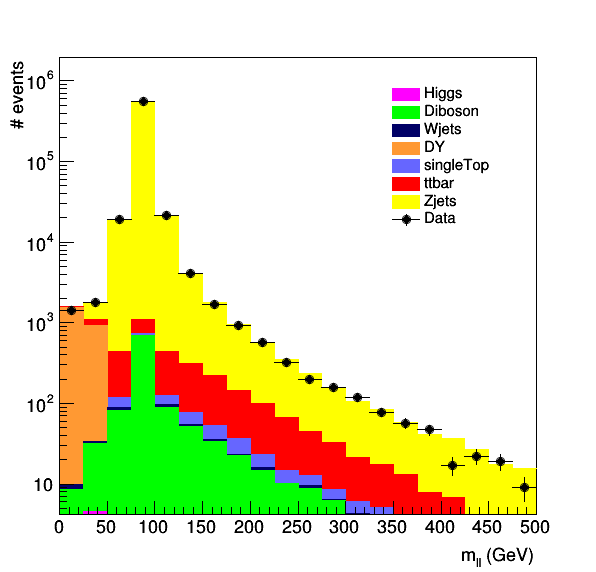

In [64]:
stack_mll.Draw("hist"); 
stack_mll.SetMaximum(1E6); 
stack_mll.GetYaxis().SetTitle("# events");
stack_mll.GetYaxis().SetTitleOffset(1.3); 
stack_mll.GetXaxis().SetTitle("m_{ll} (GeV)");
stack_mll.GetXaxis().SetTitleOffset(1.3);
hist_mll_d.Draw("same E"); 
leg.Draw();
C.Draw();

In [65]:
hist_met_d.SetLineColor(R.kBlack); 
hist_met_d.SetMarkerStyle(R.kFullCircle); 
hist_met_d.SetMarkerColor(R.kBlack); 

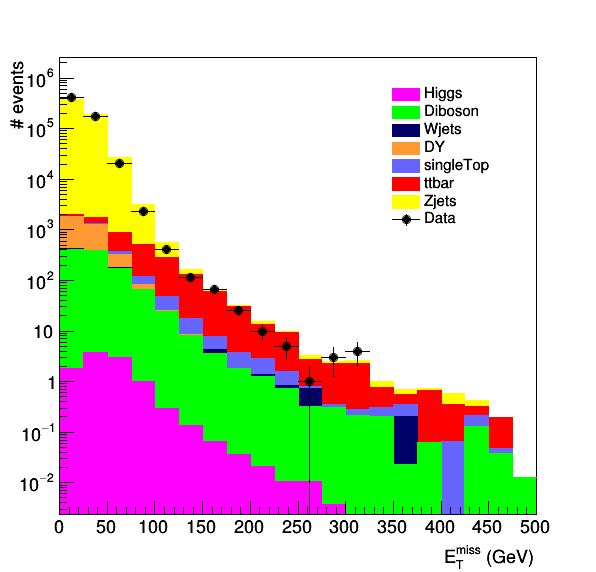

In [66]:
stack_met.Draw("hist"); 
stack_met.SetMaximum(1E6); 
stack_met.GetYaxis().SetTitle("# events");
stack_met.GetYaxis().SetTitleOffset(1.3); 
stack_met.GetXaxis().SetTitle("E_{T}^{miss} (GeV)");
stack_met.GetXaxis().SetTitleOffset(1.3);
hist_met_d.Draw("same e"); 
leg.Draw();
C.Draw(); 

In [67]:
hist_lep_pt_d.SetLineColor(R.kBlack); 
hist_lep_pt_d.SetMarkerStyle(R.kFullCircle); 
hist_lep_pt_d.SetMarkerColor(R.kBlack); 

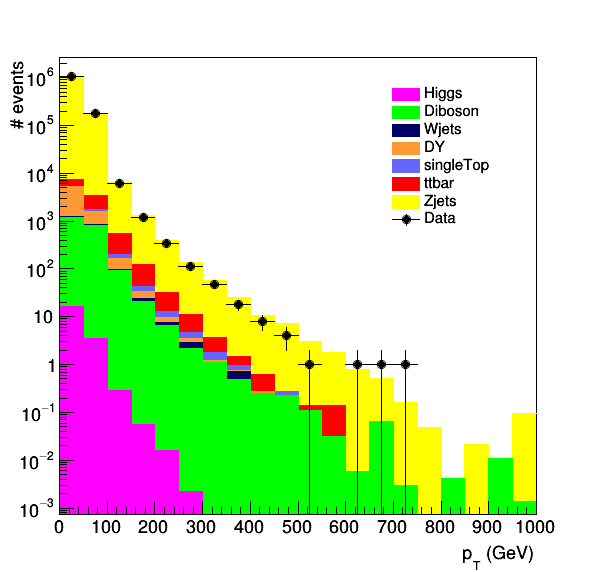

In [68]:
stack_lep_pt.Draw("hist"); 
stack_lep_pt.SetMaximum(1E6); 
stack_lep_pt.GetYaxis().SetTitle("# events");
stack_lep_pt.GetYaxis().SetTitleOffset(1.3); 
stack_lep_pt.GetXaxis().SetTitle("p_{T} (GeV)");
stack_lep_pt.GetXaxis().SetTitleOffset(1.3);
hist_lep_pt_d.Draw("same e"); 
leg.Draw();
C.Draw(); 